<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

## Regression and Classification with the Ames Housing Data

## Data cleaning

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Load the data
house = pd.read_csv('housing.csv')

In [3]:
# check whether houses are residential
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [4]:
# remove 10 commercial properties
df = house[house.MSZoning != 'C (all)'].copy()
df.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [5]:
df.Electrical.value_counts(normalize=True)

SBrkr    0.916494
FuseA    0.062112
FuseF    0.018634
FuseP    0.002070
Mix      0.000690
Name: Electrical, dtype: float64

In [6]:
df[df.GarageYrBlt.isnull()].shape[0]

79

In [7]:
len(df.GarageYrBlt.unique())

97

In [8]:
df.GarageYrBlt.corr(df.YearBuilt)

0.8296670391661415

### Cleaning data - assumptions
**Treatment of categorical variables with null values:**   
The null values for categorical variables are all due to the value being 'NA' as defined in the data description e.g. where there is no garage in the *GarageType* column. For these, use the keyword argument dummy_na=True in the pandas get_dummies function so that they are included as a category in the dummification.   

**Treatment of numerical variables with null values:**   
*LotFrontage* has 259 null values. This variable is the linear feet of street connected to a property so it makes sense to replace the null values with 0.  

**Convert numerical variables to categorical variables where relevant:**  
Some variables are defined as integers but should be treated as categorical variables, so there is no order associated with them. I will convert the following columns to string representations of the numbers so they are automatically dummified by the pandas get_dummies function: *MoSold*, *MSSubClass* (since there are so many variables, this is easier than listing all of the variables to be dummified in the pandas get_dummies function).

**Exceptions:**   
*MasVnrType* and *MasVnrArea* have 8 null values. Since it is not easy to work out the likely values, I will drop these 8 rows. Perhaps revisit with them set to the mode and mean respectively afterwards.  
*Electrical* has 1 null value. Since 92% of the values for Electrical are 'SBrkr', replace with 'SBrkr'.  
*GarageYrBlt* has 79 null values corresponding to the properties with no garages. Since there are 96 unique years in this column it would not make sense to treat this as a categorical variable. This variable has a high correlation of 83% with the YearBuilt variable for the property so I will drop the variable altogether for this analysis.

In [9]:
# replace NaN values with 0 for LotFrontage
df.LotFrontage.replace({np.nan : 0}, inplace=True)

In [10]:
# convert MoSold and MSSubClass to strings to be used as categorical variables
df.MoSold = df.MoSold.astype(str)
df.MSSubClass = df.MSSubClass.astype(str)

In [11]:
# drop rows with null values in MasVnrType
indices_to_drop = df[df.MasVnrType.isnull()].index
df.drop(index=indices_to_drop, inplace=True)

In [12]:
# replace null values in Electrical with 'SBrkr' (the mode value)
df.Electrical.replace({np.nan : 'SBrkr'}, inplace=True)

In [13]:
# drop GarageYrBlt column
df.drop(columns=['GarageYrBlt'], inplace=True)

In [14]:
# save data to CSV
df.to_csv('housing_clean.csv', index=False)

### Initial EDA - Fixed Features

In [15]:
# define lists of fixed features and renovateable features
fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
                  'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
                  'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                  'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'Foundation', 
                  'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                  'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                  'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 
                  'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal']

renovateable_features = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 
                         'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond',
                         'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                         'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                         'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

len(fixed_features), len(renovateable_features)

(50, 24)

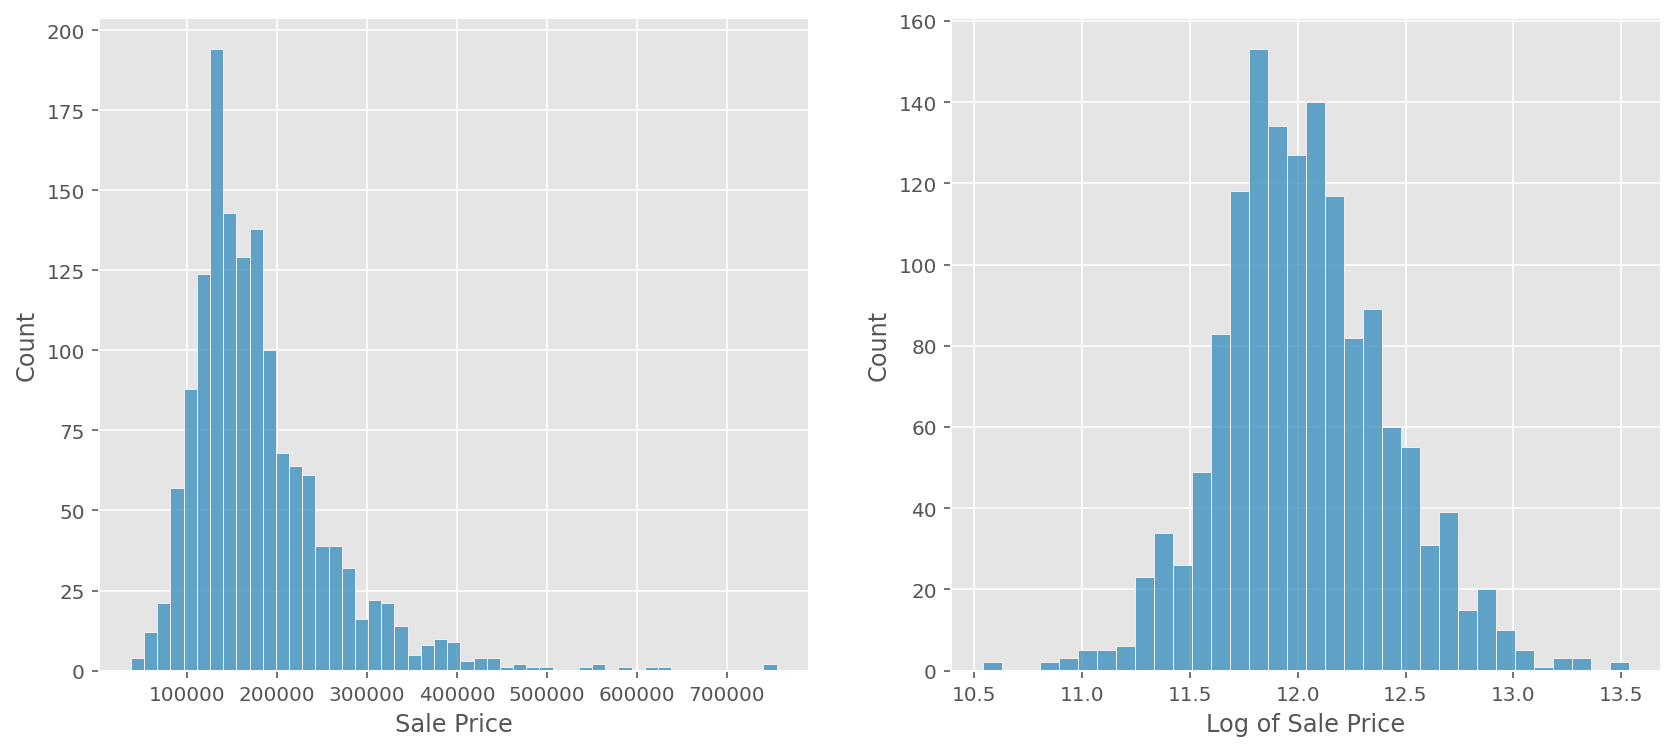

In [16]:
# plot histogram of the sale price and log sale price
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
sns.histplot(df.SalePrice, ax=ax[0])
sns.histplot(np.log(df.SalePrice), ax=ax[1])
ax[0].set_xlabel('Sale Price')
ax[1].set_xlabel('Log of Sale Price')
plt.show()

In [17]:
# create pair plots with numerical variables vs sale price and vs log sale price
df_pp = df.copy()
df_pp['LogSalePrice'] = np.log(df.SalePrice)
pairplot_features_1 = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'GrLivArea', 'TotRmsAbvGrd']
pairplot_features_2 = ['TotalBsmtSF', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
pairplot_features_3 = ['MasVnrArea', 'GarageCars', 'OverallQual', 'OverallCond']

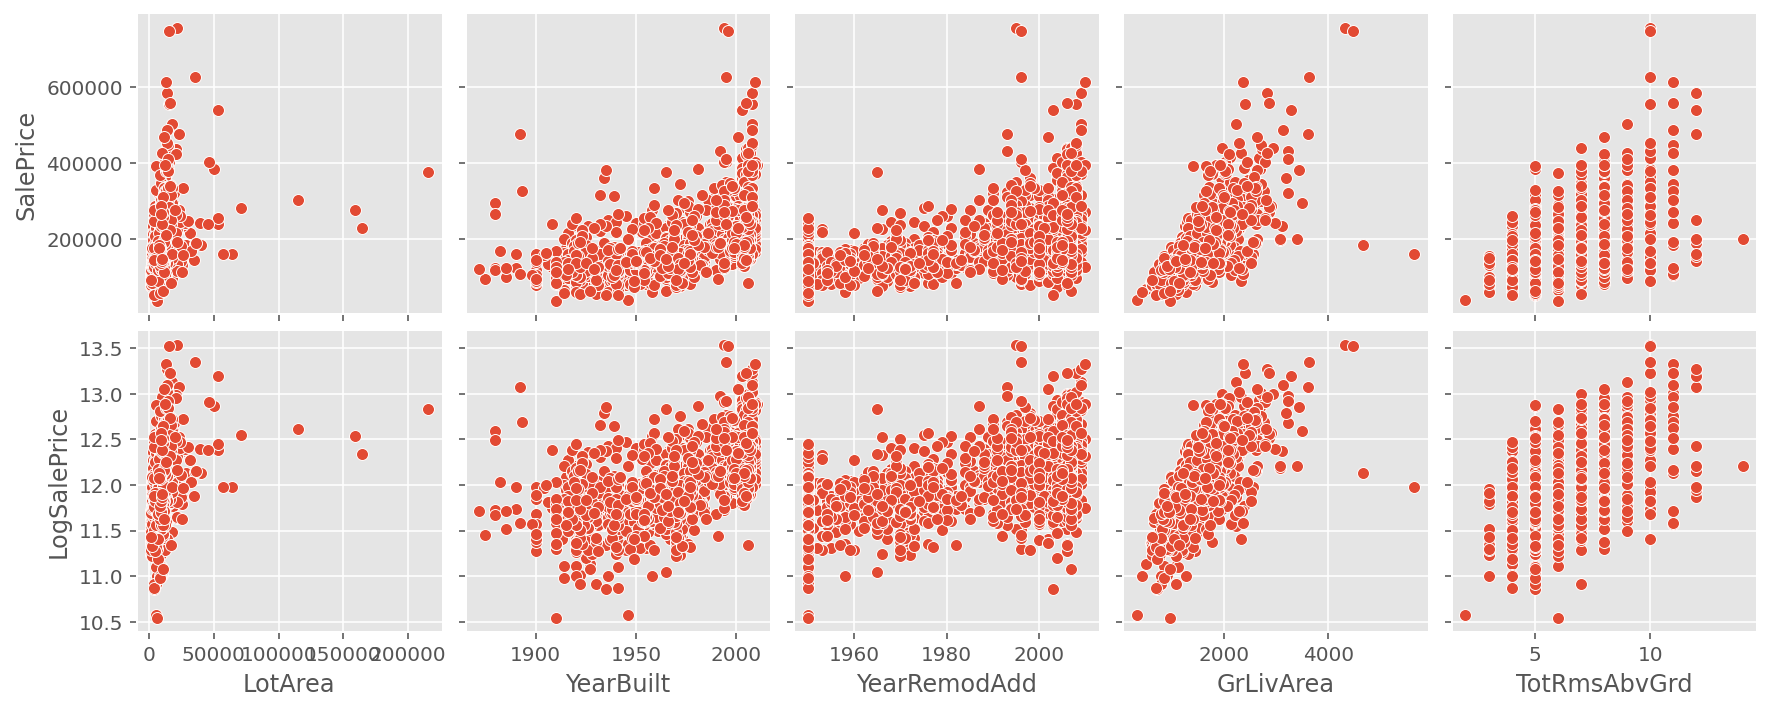

In [18]:
sns.pairplot(data=df_pp, x_vars=pairplot_features_1, y_vars=['SalePrice', 'LogSalePrice'], diag_kind=None);

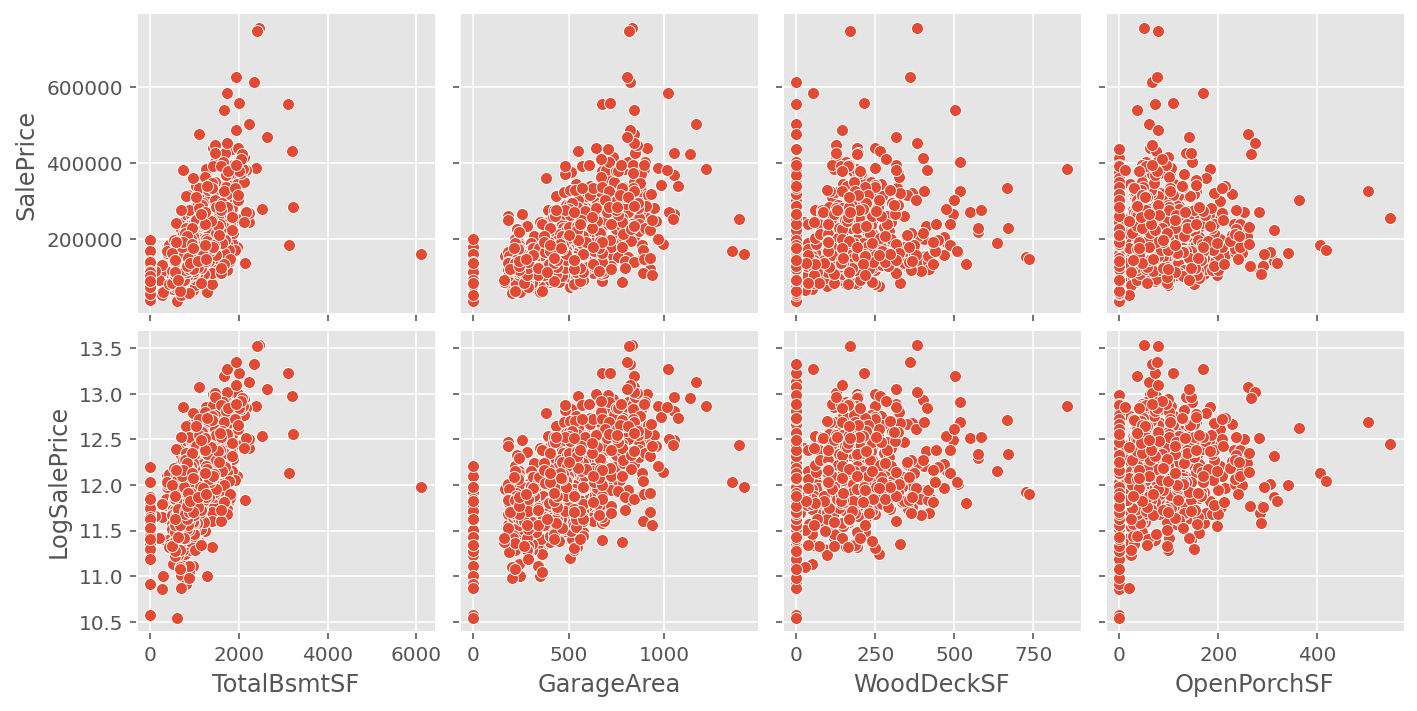

In [19]:
sns.pairplot(data=df_pp, x_vars=pairplot_features_2, y_vars=['SalePrice', 'LogSalePrice'], diag_kind=None);

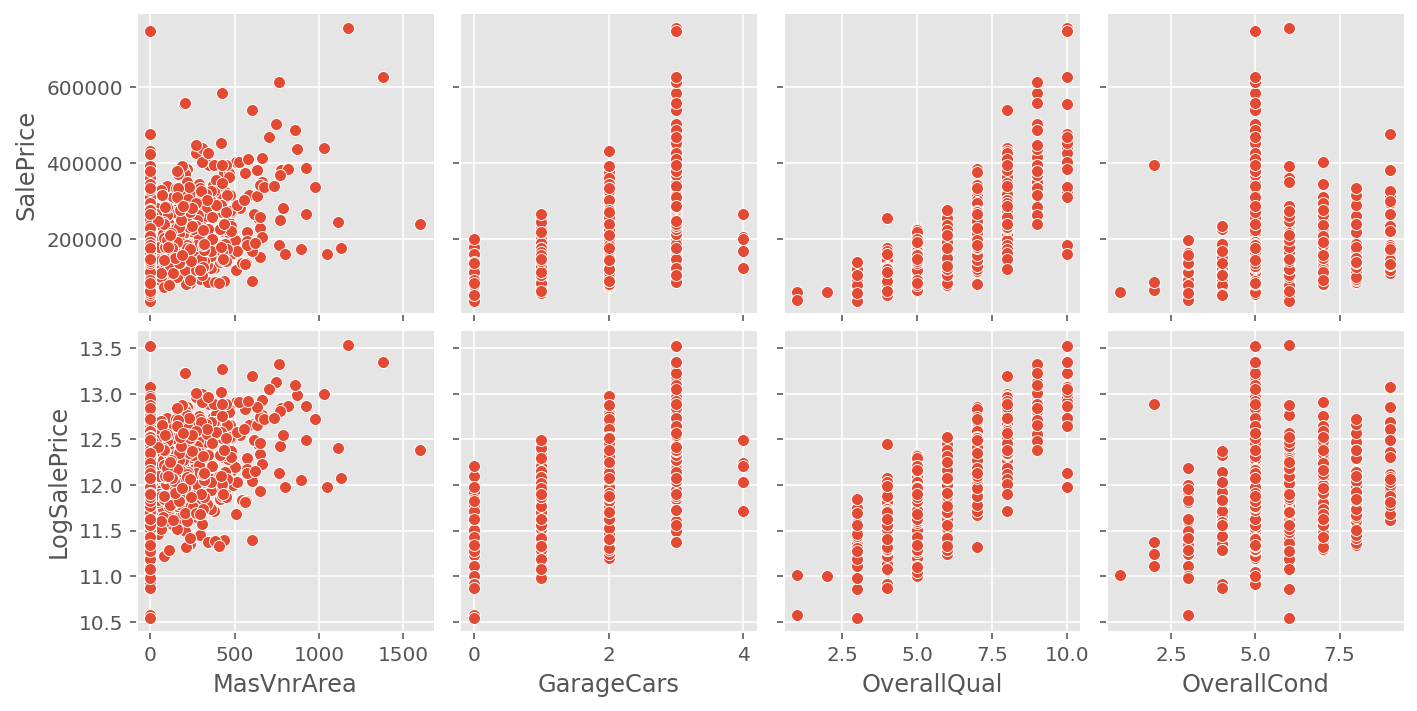

In [20]:
sns.pairplot(data=df_pp, x_vars=pairplot_features_3, y_vars=['SalePrice', 'LogSalePrice'], diag_kind=None);

#### Distribution of the target variable
The distribution of the sale price has positive skew - most of the values are clustered to the left of the distribution i.e. at lower sale prices. The histogram above on the right shows the distribution of the sale prices after a log transformation. This distribution is much closer to a normal distribution.  

The scatter plots show the relationships between some of the numerical predictor variables and the sale price and also the log of the sale price. Some of the relationships appear more linear versus the log sale price, for example OverallQual which is likely to be an important predictor for part 2.   

Therefore I will look at modelling with the log of the sale price as my target variable, as well as the untransformed sale price.

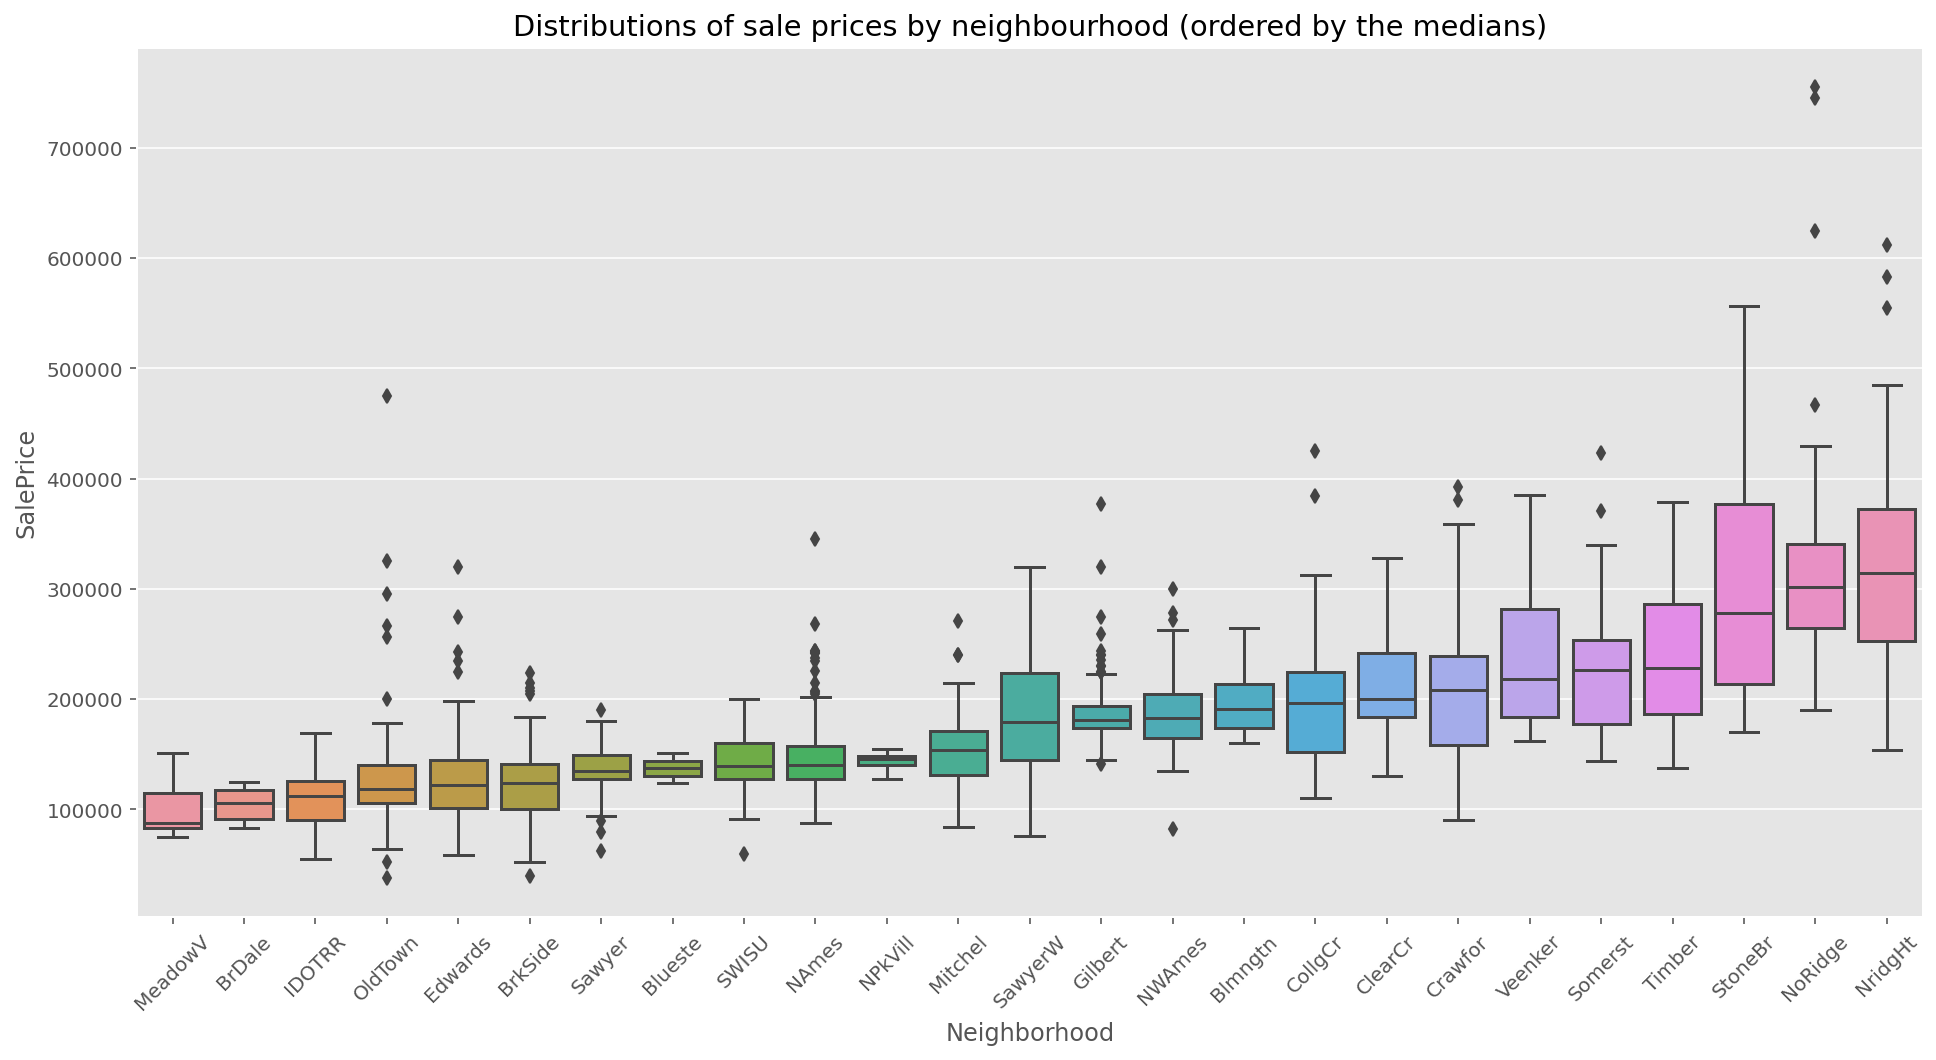

In [21]:
# boxplots of sale prices by neighbourhood
fig, ax = plt.subplots(figsize=(16, 8))
boxplot_order = df_pp.groupby('Neighborhood').SalePrice.median().sort_values().index
sns.boxplot(data=df_pp, x='Neighborhood', y='SalePrice', order=boxplot_order)
plt.xticks(rotation=45)
plt.title('Distributions of sale prices by neighbourhood (ordered by the medians)')
plt.show()

#### Check some of the 'outliers' identified in the scatter plots

In [23]:
# check the 4 largest values in LotArea which seem to have a relatively lower price
# they all have LandSlope = Sev i.e. the slope of the property is severe, which could explain this
# especially as there are only 13 instances in the dataset with LandSlope = Sev
df[df.LotArea > 100000].iloc[:, 10:16]

,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType
249,CulDSac,Sev,ClearCr,Norm,Norm,1Fam
313,Inside,Sev,Timber,Norm,Norm,1Fam
335,Corner,Sev,Timber,Norm,Norm,2fmCon
706,CulDSac,Sev,ClearCr,Norm,Norm,1Fam


In [24]:
df.LandSlope.value_counts()

Gtl    1367
Mod      62
Sev      13
Name: LandSlope, dtype: int64

In [25]:
# check the row with TotalBsmtSF > 6000 to see if it is an outlier
# SaleCondition is 'Partial' meaning that the home was not completed when last assessed
df[df.TotalBsmtSF > 6000].iloc[:, 70:]

,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [26]:
# check the values with GrLivArea > 4000 to check for outliers
# there are two values with a large area and low sale price
# these are also classifed with SaleCondition as 'Partial'
df[df.GrLivArea > 4000].iloc[:, 70:]

,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


#### Further data cleaning

**SaleCondition:**   
The scatter plots above show some outliers with e.g. large square footage but a low price. Upon further investigation these outliers all have SaleCondition = Partial i.e. the home was not completed at the time of the sale because it was a new build. Since new homes are unlikely to need any renovation they are not relevant for this analysis so I will remove all instances with SaleCondition = Partial for modelling in parts 1 and 2. This removes 122 instances from the dataset, leaving 1320 in total.   
I did test the model with these sales included - the overall score was still good but there was much more fluctuation in the cross-validated scores.

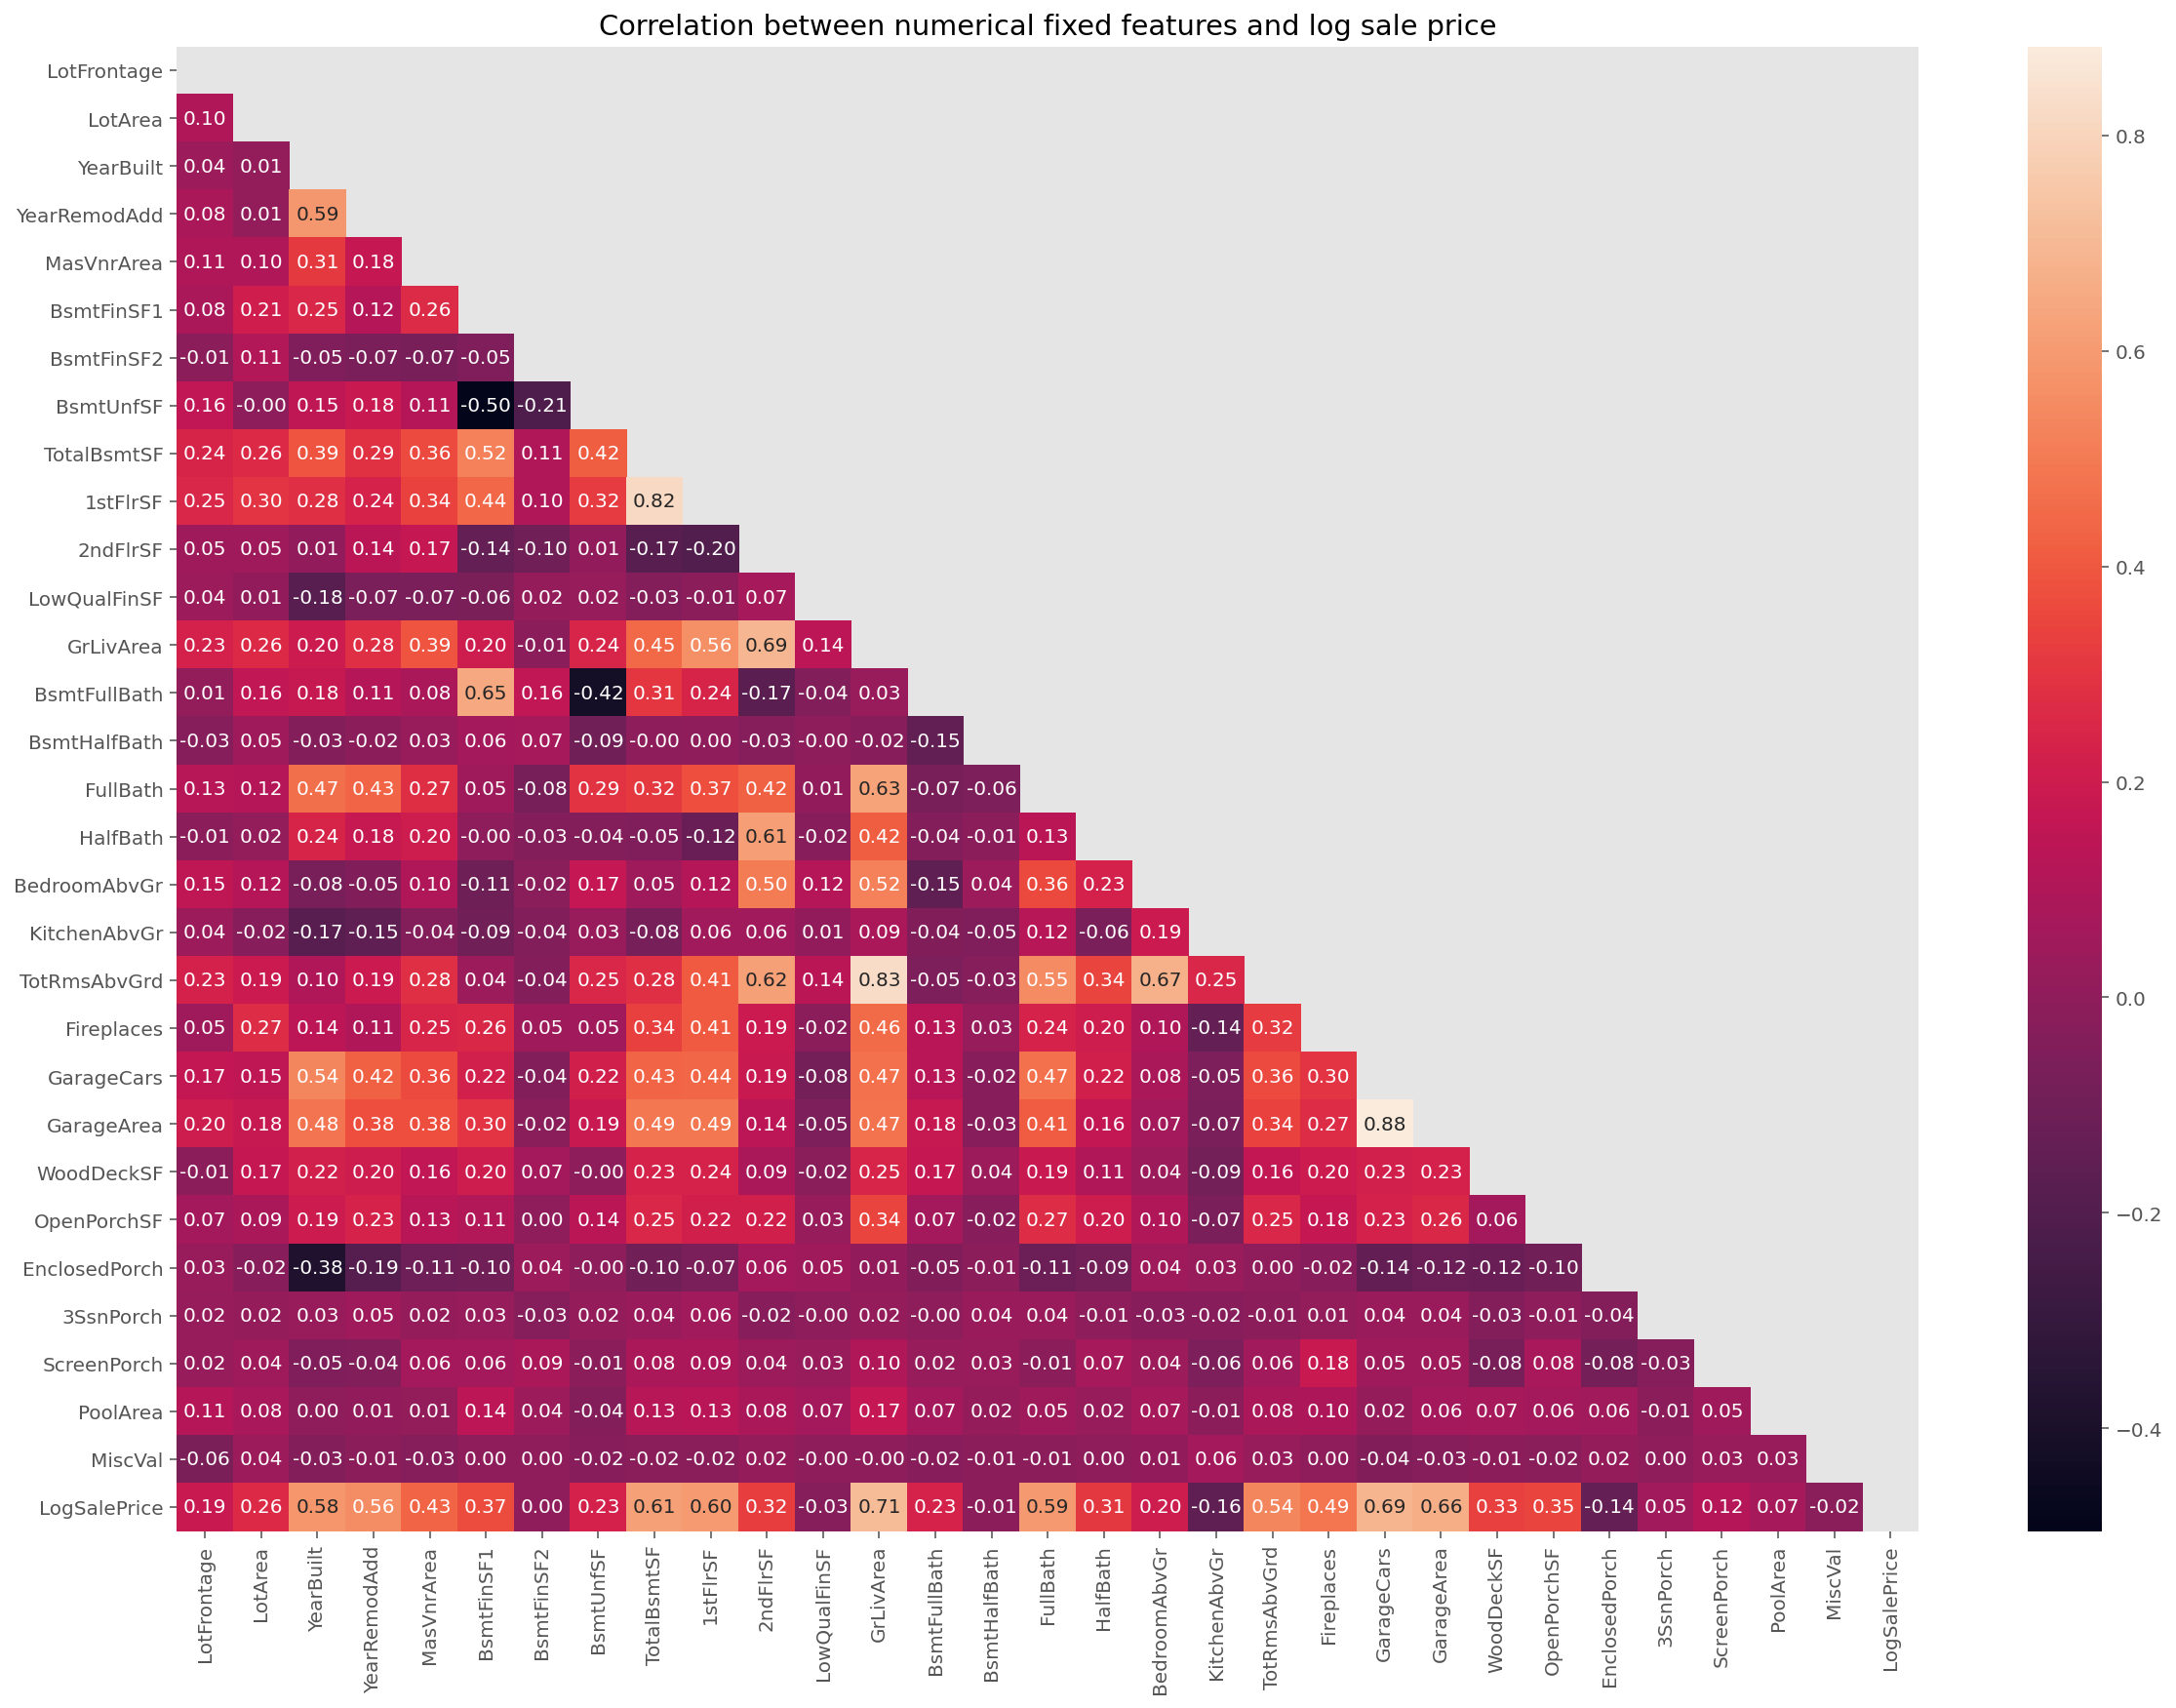

In [27]:
# calculate pairwise correlations between numerical fixed features and sale price
fixed_corr = df_pp[fixed_features + ['LogSalePrice']].corr()

# set the  matplotlib figure size:
fig, ax = plt.subplots(figsize=(20, 14))

# generate a mask for the upper triangle
mask = np.zeros_like(fixed_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap with seaborn
sns.heatmap(fixed_corr, mask=mask, annot=True, fmt='.2f', ax=ax)
ax.set_ylim([fixed_corr.shape[1], 0])
plt.title('Correlation between numerical fixed features and log sale price')
plt.show()

#### Heatmap analysis

The heatmap above shows the pairwise correlations between the numerical fixed features and the log sale price. The *GrLivArea* (above ground living area square feet) has the highest positive correlation with the log sale price (0.71) so should be a good predictor. Other square footage variables also have high positive correlations (e.g. *1stFlrSF*, *TotalBsmtSF*, *GarageArea*). *TotalRmsAbvGrd* and *GarageCars* (size of garage in cars capacity) also have reasonable positive correlation with the log sale price. *YearBuilt* and *YearRemodAdd* (remodel date) have positive correlations of 0.58 and 0.56 respectively with the log sale price so might also be quite good predictors.   

Many of the variables have high correlation between themselves (e.g. the different square footage variables). Therefore it is likely that a standard linear regression model will not work well and regularization will be required to reduce the multicollinearity.

### Initial EDA - Renovateable Features

In [28]:
df_pp[renovateable_features + ['SalePrice', 'LogSalePrice']].corr()

,OverallQual,OverallCond,SalePrice,LogSalePrice
OverallQual,1.000000,-0.106658,0.788026,0.815953
OverallCond,-0.106658,1.000000,-0.087588,-0.054694
SalePrice,0.788026,-0.087588,1.000000,0.952113
LogSalePrice,0.815953,-0.054694,0.952113,1.000000


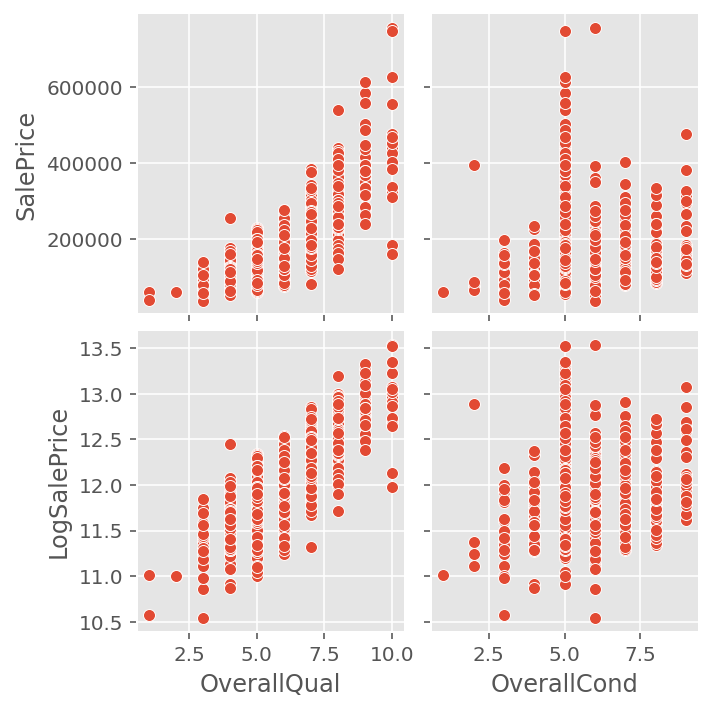

In [29]:
sns.pairplot(df_pp, x_vars=['OverallQual', 'OverallCond'], y_vars=['SalePrice', 'LogSalePrice'], diag_kind=None);